In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import holidays
from sklearn.model_selection import ParameterGrid
import random
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
import pickle
import os

In [160]:
data = pd.read_csv('/content/all_data.csv', parse_dates=['_time'])
# data = data[~((data['_time'] == '2023-07-31'))]
data = data[~((data['_time'] == '2023-09-01'))]
data = data[['_time', 'panel_no', '_value_kwh', '_value_pcm']]
# Define the new column names
new_column_names = {'_time': 'Date',
                    'panel_no': 'StoreName',
                    '_value_kwh': 'EnergyConsumed',
                    '_value_pcm': 'PeopleVisited'}

# Rename columns
data.rename(columns=new_column_names, inplace=True)
new_store_names = ['Mumbai', 'Pune', 'Nagpur', 'Kolhapur', 'Nashik', 'Thane', 'Amravati', 'Nanded', 'Gondia', 'Satara', 'Solapur', 'Akola', 'Sangli', 'Palghar', 'Jalgaon']
data['StoreName'].replace(dict(zip(data['StoreName'].unique(), new_store_names)), inplace=True)
data

,Date,StoreName,EnergyConsumed,PeopleVisited
0,2023-07-31,Mumbai,196.300000,NaN
1,2023-08-01,Mumbai,201.900000,419.0
2,2023-08-02,Mumbai,211.600000,604.0
3,2023-08-03,Mumbai,211.600000,568.0
4,2023-08-04,Mumbai,218.900000,570.0
...,...,...,...,...
489,2023-08-27,Jalgaon,742.666667,185.0
490,2023-08-28,Jalgaon,789.966667,129.0
491,2023-08-29,Jalgaon,603.833333,163.0
492,2023-08-30,Jalgaon,664.733333,106.0


In [161]:
data.isnull().sum()

Date               0
StoreName          0
EnergyConsumed     0
PeopleVisited     86
dtype: int64

In [162]:
# data[data['_value_kwh']==0]

In [163]:
# data = data.fillna(data.mean())

In [164]:
# Define a function to fill null values in '_value_pcm' column based on the average of the same weekday
def fill_null_with_weekday_average(row):
    if pd.isnull(row['PeopleVisited']):
        weekday = row['Date'].weekday()  # Get the day of the week (Monday is 0, Sunday is 6)
        weekday_values = data[data['Date'].dt.weekday == weekday]['PeopleVisited']
        weekday_average = weekday_values.mean()
        return weekday_average
    else:
        return row['PeopleVisited']

# Apply the function to fill null values in '_value_pcm' column
data['PeopleVisited'] = data.apply(fill_null_with_weekday_average, axis=1)
data

,Date,StoreName,EnergyConsumed,PeopleVisited
0,2023-07-31,Mumbai,196.300000,696.862745
1,2023-08-01,Mumbai,201.900000,419.000000
2,2023-08-02,Mumbai,211.600000,604.000000
3,2023-08-03,Mumbai,211.600000,568.000000
4,2023-08-04,Mumbai,218.900000,570.000000
...,...,...,...,...
489,2023-08-27,Jalgaon,742.666667,185.000000
490,2023-08-28,Jalgaon,789.966667,129.000000
491,2023-08-29,Jalgaon,603.833333,163.000000
492,2023-08-30,Jalgaon,664.733333,106.000000


In [165]:
data.isnull().sum()

Date              0
StoreName         0
EnergyConsumed    0
PeopleVisited     0
dtype: int64

In [166]:
data = data.groupby(['Date', 'StoreName']).agg({'EnergyConsumed': 'sum', 'PeopleVisited': 'sum'}).reset_index()
data = data.sort_values(by=['Date']).reset_index(drop=True)
data

,Date,StoreName,EnergyConsumed,PeopleVisited
0,2023-07-31,Akola,401.800000,696.862745
1,2023-07-31,Thane,552.950000,696.862745
2,2023-07-31,Solapur,38.200000,696.862745
3,2023-07-31,Satara,521.916667,696.862745
4,2023-07-31,Sangli,484.650000,696.862745
...,...,...,...,...
475,2023-08-31,Amravati,287.700000,260.375000
476,2023-08-31,Akola,433.100000,186.000000
477,2023-08-31,Solapur,40.833333,288.000000
478,2023-08-31,Nagpur,342.300000,156.000000


In [167]:
data['StoreName'].value_counts()

Akola       32
Thane       32
Solapur     32
Satara      32
Sangli      32
Palghar     32
Nashik      32
Pune        32
Nagpur      32
Mumbai      32
Kolhapur    32
Jalgaon     32
Gondia      32
Amravati    32
Nanded      32
Name: StoreName, dtype: int64

In [168]:
# @title
# Get holidays for India for the specified years
holiday_df = pd.DataFrame([])
for date, name in sorted(holidays.India(years=[2023]).items()):
    holiday_df = holiday_df.append(pd.DataFrame({'ds': date, 'holiday': name}, index=[0]), ignore_index=True)

# Convert 'ds' column to datetime format
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'], format='%Y-%m-%d', errors='ignore')
# holiday_df
# Define the holidays where you want to adjust the lower window
holidays_to_adjust_10 = ['Diwali']
holidays_to_adjust_5 = ['Makar Sankranti / Pongal']
holidays_to_adjust_3 = ['Christmas Day']
# holidays_to_remove = ['Day of Ashura* (*estimated)','Holi','Mawlid* (*estimated)','Labour Day','Palm Sunday','Eid ul-Fitr* (*estimated)']
# holiday_df = holiday_df[~holiday_df['holiday'].isin(holidays_to_remove)]

# Adjust lower window for specified holidays
holiday_df.loc[holiday_df['holiday'].isin(holidays_to_adjust_10), 'lower_window'] = -10
holiday_df.loc[holiday_df['holiday'].isin(holidays_to_adjust_10), 'upper_window'] = 0
holidays_to_remove = ['Day of Ashura* (*estimated)','Holi',
                      'Mawlid (estimated)','Labour Day','Palm Sunday',
                      'Eid ul-Fitr* (*estimated)', 'Tamil New Year', 'Good Friday',
                      'Easter Sunday', 'Eid ul-Fitr (estimated)','Eid ul-Fitr (estimated)',
                      'Feast of Pentecost','Eid al-Adha (estimated)','Eid al-Adha (estimated)']
holiday_df = holiday_df[~holiday_df['holiday'].isin(holidays_to_remove)]

holiday_df.loc[holiday_df['holiday'].isin(holidays_to_adjust_5), 'lower_window'] = -5


holiday_df.loc[holiday_df['holiday'].isin(holidays_to_adjust_3), 'lower_window'] = -3


holiday_df['lower_window'].fillna(0, inplace=True)  # Set default lower window as 0 for holidays not specified

holiday_df['upper_window'].fillna(1, inplace=True)  # Set default lower window as 0 for holidays not specified

# Add New Year as a holiday with lower window 5 for the years 2022 and 2023
new_year_holidays = pd.DataFrame({
    'ds': pd.to_datetime(['2023-12-31', '2023-09-18']),
    'holiday': ['New Year', 'Vinayaka Chaturthi'],
    'lower_window': [-1, -2],
    'upper_window': [1, 1]
})

# Append new year holidays to the dataframe
holiday_df = holiday_df.append(new_year_holidays, ignore_index=True)
holiday_df = holiday_df.sort_values('ds').reset_index(drop=True)
holiday_df

,ds,holiday,lower_window,upper_window
0,2023-01-14,Makar Sankranti / Pongal,-5.0,1.0
1,2023-01-26,Republic Day,0.0,1.0
2,2023-07-28,Day of Ashura (estimated),0.0,1.0
3,2023-08-15,Independence Day,0.0,1.0
4,2023-09-18,Vinayaka Chaturthi,-2.0,1.0
5,2023-10-02,Gandhi Jayanti,0.0,1.0
6,2023-11-12,Diwali,-10.0,0.0
7,2023-12-25,Christmas Day,-3.0,1.0
8,2023-12-31,New Year,-1.0,1.0


In [169]:
def forecast_drill_down_store_all(data, store_name='StoreName', forecast_period=30, holiday=None):
    # Filter data based on selected parameters
    # group_levels=['BillDate','StoreName','Department','ProductCategoryName','BrandName']
    group_levels=[]
    group_levels.append('Date')
    # group_levels.append('UnitMRP')
    if store_name != 'ALL':
      data = data[data['StoreName'] == store_name]
      group_levels.append('StoreName')


    print(group_levels)

    # Group by 'date' and aggregate columns
    agg_dict_amount = {
        'EnergyConsumed': 'sum',
    }

    data_amount = data.groupby(group_levels).agg(agg_dict_amount).reset_index()
    data_amount = data_amount.rename(columns={'Date': 'ds', 'EnergyConsumed': 'y'})

    # Group by 'date' and aggregate columns for 'Quantity'
    agg_dict_quantity = {
        'PeopleVisited': 'sum',
    }
    data_quantity = data.groupby(group_levels).agg(agg_dict_quantity).reset_index()
    data_quantity = data_quantity.rename(columns={'Date': 'ds', 'PeopleVisited': 'y'})

    # # Merge the 'Amount' and 'Quantity' DataFrames on 'ds' column
    # data_combined = pd.merge(data_amount, data_quantity, on='ds', how='inner')


    # strt='2023-09-30'
    # end='2023-10-31'

    final_model_amount = Prophet (
                        growth="linear",
                        holidays=holiday,
                        seasonality_mode="additive",
                        # changepoint_prior_scale=0.8,
                        # seasonality_prior_scale=20,
                        # holidays_prior_scale=30,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=False,
                        # ). add_seasonality(
                        # name= 'monthly',
                        # period=30.5,
                        # fourier_order=30
                        # # # ).add_seasonality(
                        # # name = "daily",
                        # # period = 1,
                        # # fourier_order=25
                        # ).add_seasonality(
                        # name="weekly",
                        # period = 7,
                        # fourier_order=35
                        # # ).add_seasonality(
                        # # name="yearly",
                        # # period = 365.25,
                        # # fourier_order=30
                        # ).add_seasonality(
                        # name = "quarterly",
                        # period = 365.25/4,
                        # fourier_order=5,
                        # prior_scale = 10
                        )






    # final_model_amount.add_country_holidays(country_name='IN')
    final_model_amount.fit(data_amount)



    final_model_quantity = Prophet (
                        growth="linear",
                        holidays=holiday,
                        seasonality_mode="additive",
                        # changepoint_prior_scale=0.8,
                        # seasonality_prior_scale=20,
                        # holidays_prior_scale=30,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=False,
                        # ). add_seasonality(
                        # name= 'monthly',
                        # period=30.5,
                        # fourier_order=30
                        # # ).add_seasonality(
                        # # name = "daily",
                        # # period = 1,
                        # # fourier_order=25
                        # ).add_seasonality(
                        # name="weekly",
                        # period = 7,
                        # fourier_order=35
                        # # ).add_seasonality(
                        # # name="yearly",
                        # # period = 365.25,
                        # # fourier_order=20
                        # ).add_seasonality(
                        # name = "quarterly",
                        # period = 365.25/4,
                        # fourier_order=5,
                        # prior_scale = 10
                        )


    # final_model_quantity.add_country_holidays(country_name='IN')
    final_model_quantity.fit(data_quantity)


    future_amount = final_model_amount.make_future_dataframe(periods=forecast_period, freq='D', include_history=True) #, include_history=False
    future_quantity = final_model_quantity.make_future_dataframe(periods=forecast_period, freq='D', include_history=True) #, include_history=False

    forecast_amount = final_model_amount.predict(future_amount)
    forecast_quantity = final_model_quantity.predict(future_quantity)

    actual_amount = data_amount[['ds', 'y']]
    actual_quantity = data_quantity[['ds', 'y']]

    final_df = pd.DataFrame({
        'Date': forecast_amount['ds'],
        'StoreName': store_name,
        'Forecasted EnergyConsumed':  np.round(forecast_amount['yhat']).astype(int),
        'Forecasted PeopleVisited': np.round(forecast_quantity['yhat']).astype(int)
    })

    plt.figure(figsize=(12, 6))
    plt.plot(actual_amount['ds'], actual_amount['y'], label='Actual EnergyConsumed', color='blue')
    plt.plot(forecast_amount['ds'], forecast_amount['yhat'], label='Predicted EnergyConsumed', color='red')
    plt.title(f"EnergyConsumed Forecast for {store_name} ")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(actual_quantity['ds'], actual_quantity['y'], label='Actual PeopleVisited', color='green')
    plt.plot(forecast_quantity['ds'], forecast_quantity['yhat'], label='Predicted PeopleVisited', color='orange')
    plt.title(f"PeopleVisited Forecast for {store_name} ")
    plt.legend()
    plt.show()

    return final_df

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


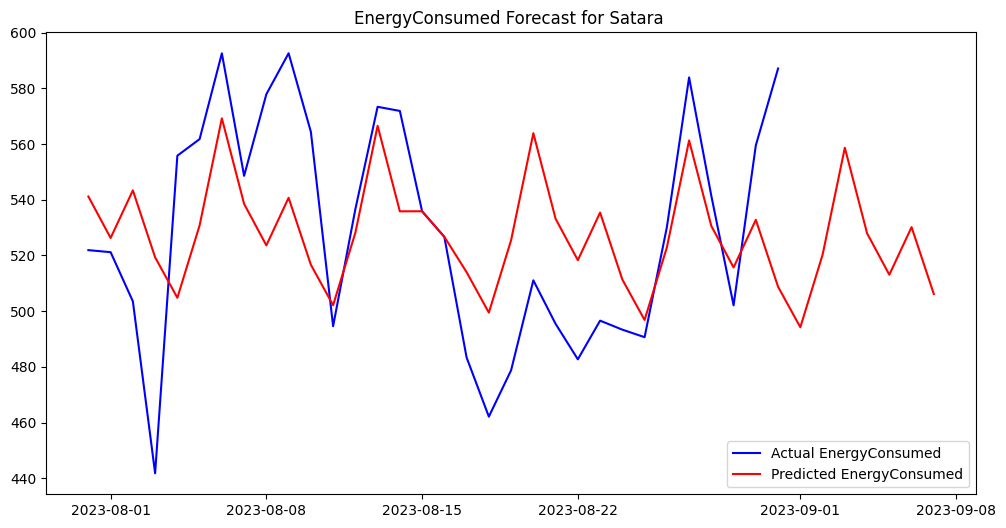

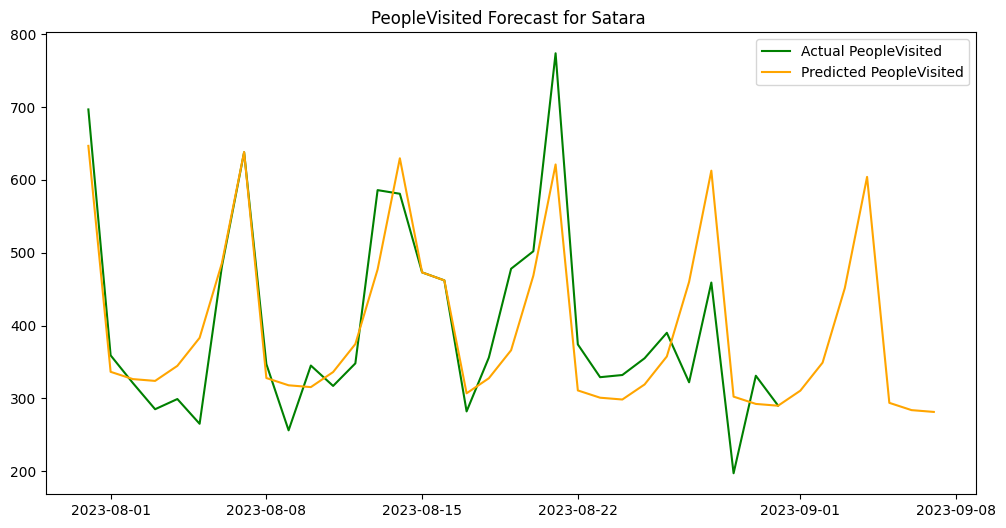

In [170]:
final_df = forecast_drill_down_store_all(data, store_name='Satara',forecast_period=7, holiday=holiday_df)


INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


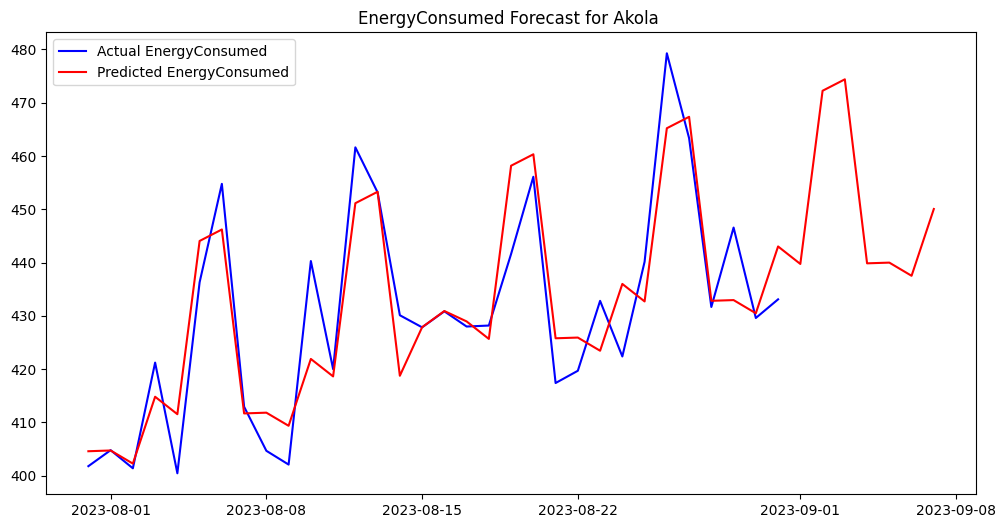

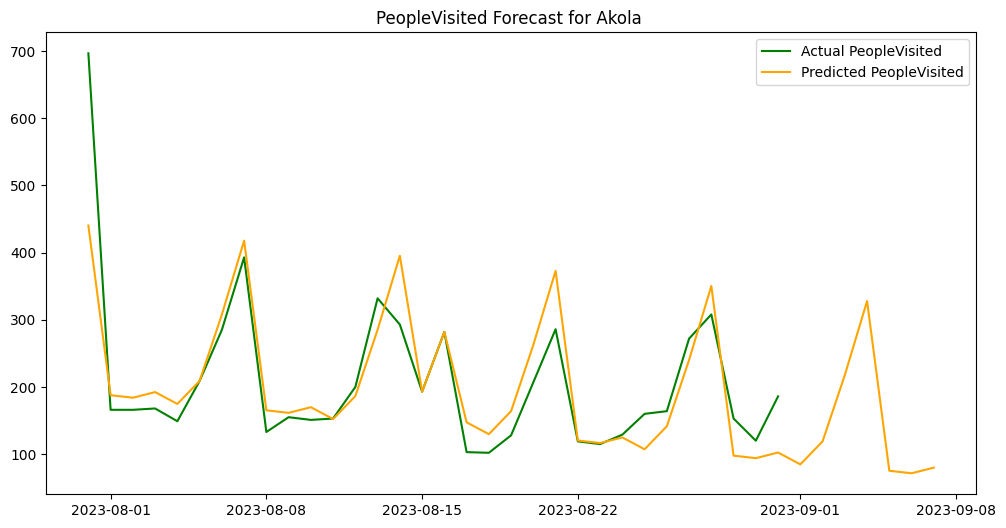

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


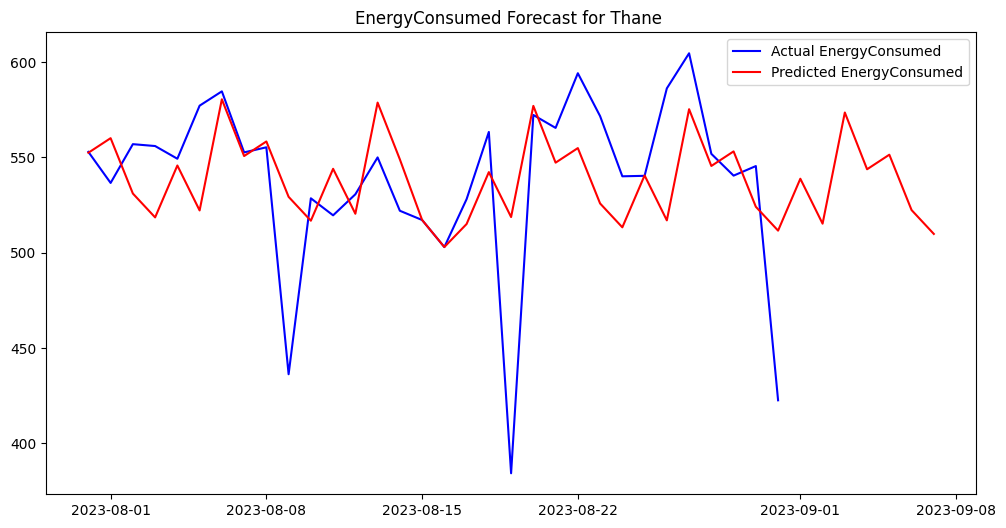

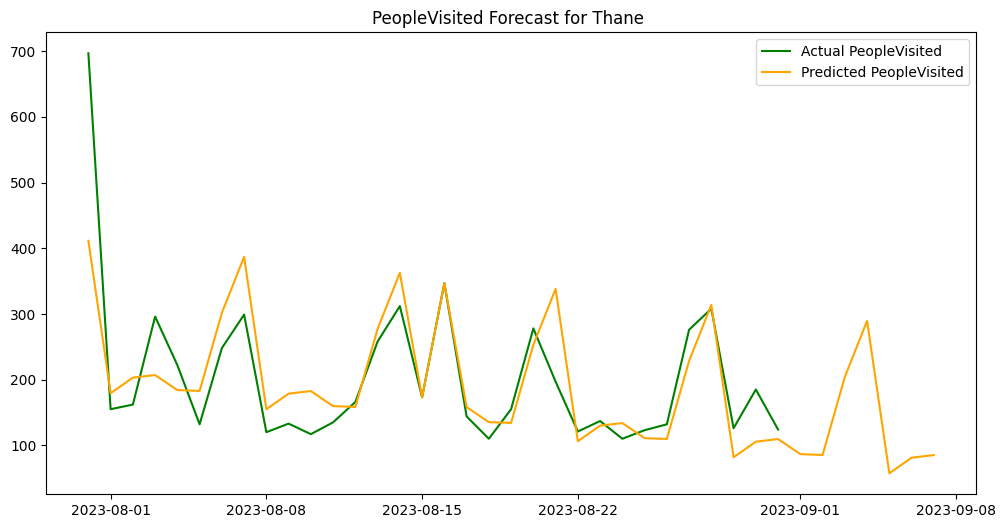

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


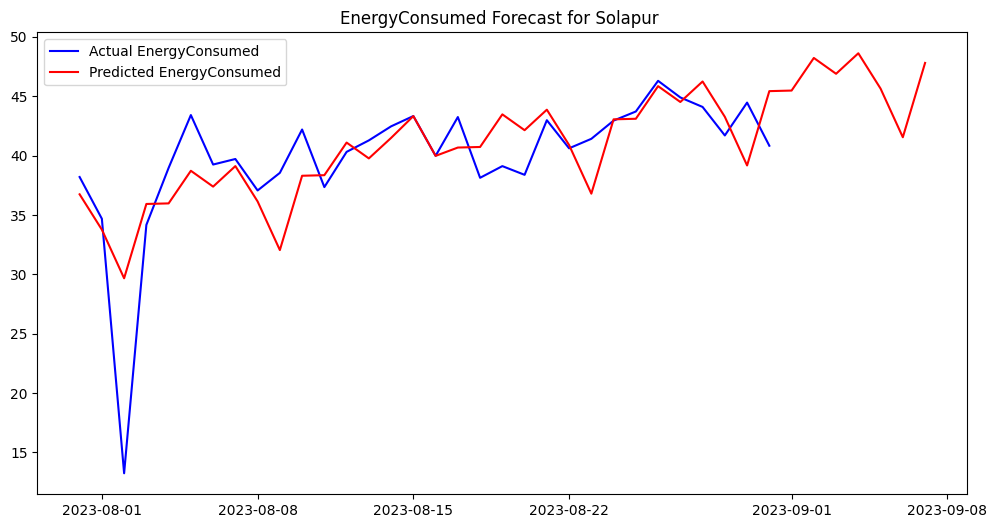

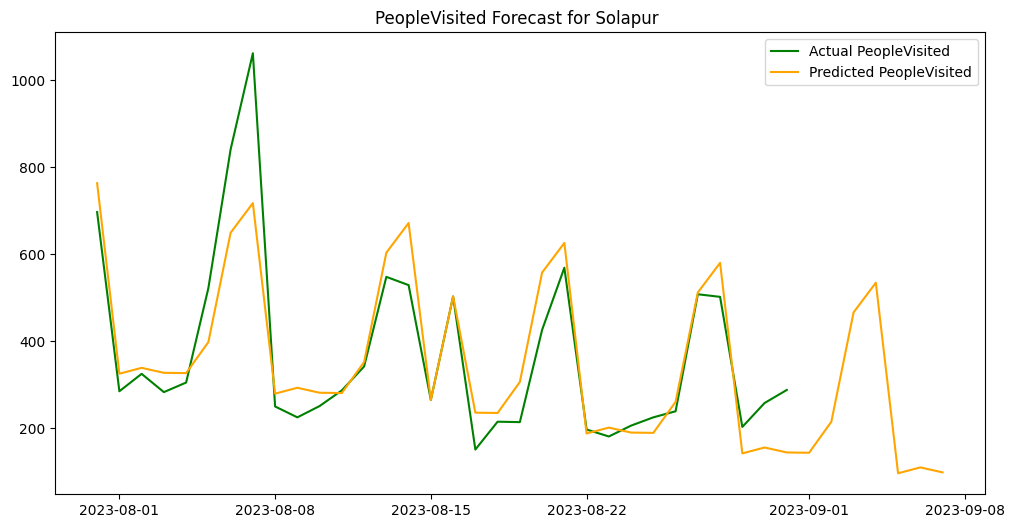

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


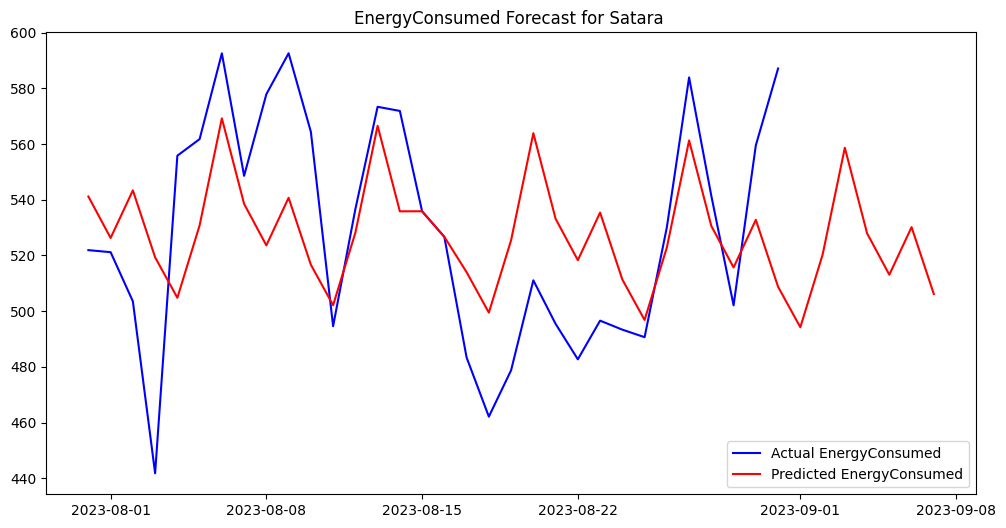

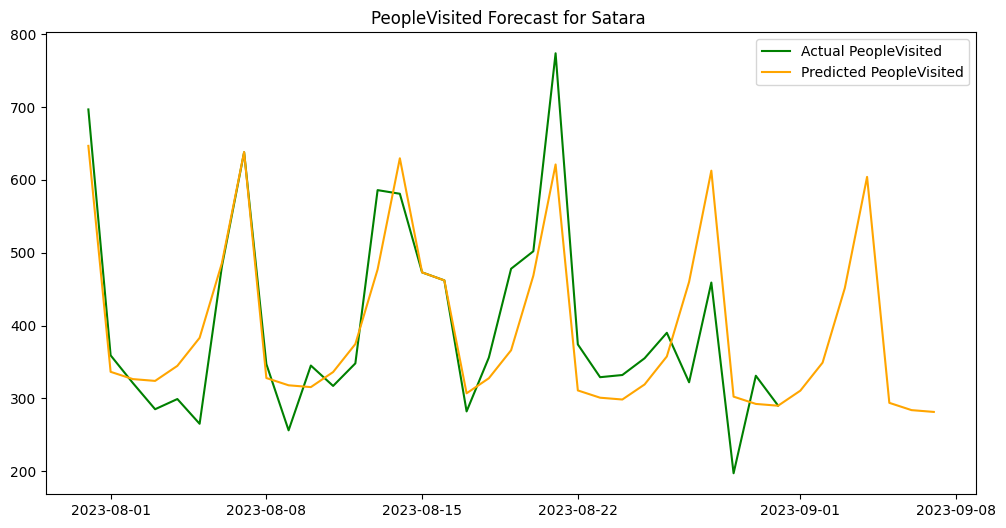

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


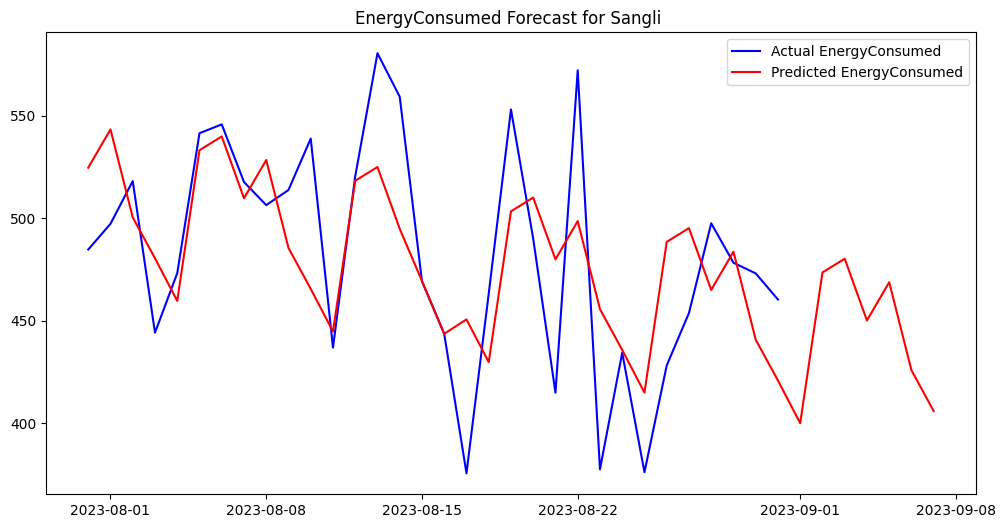

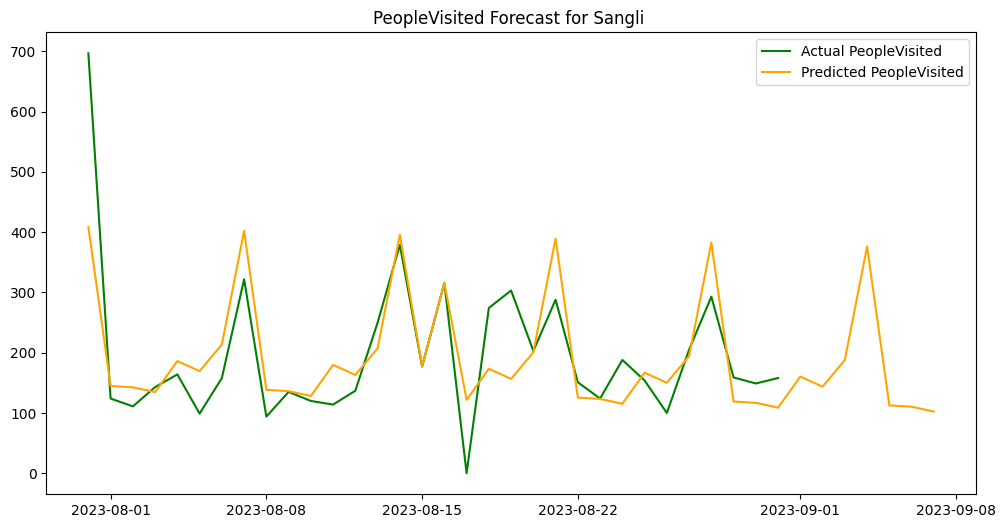

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


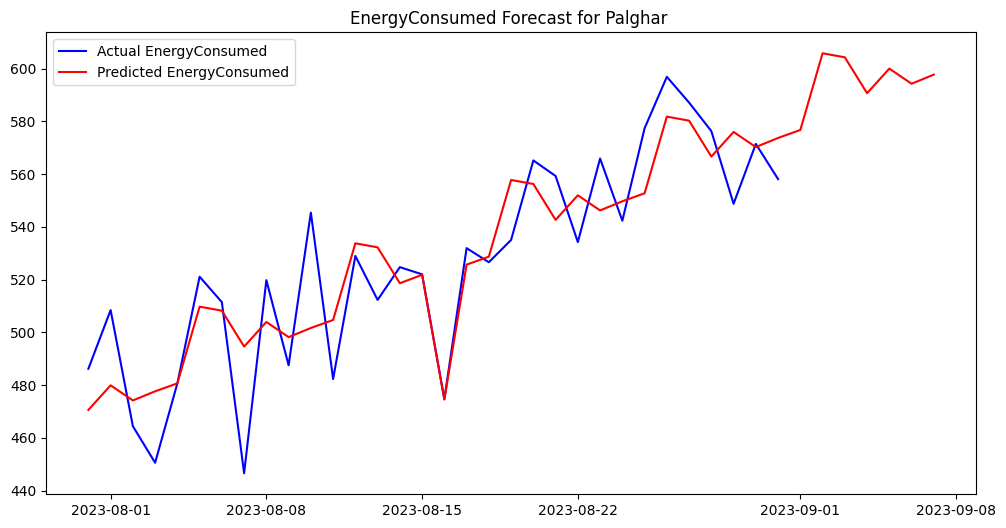

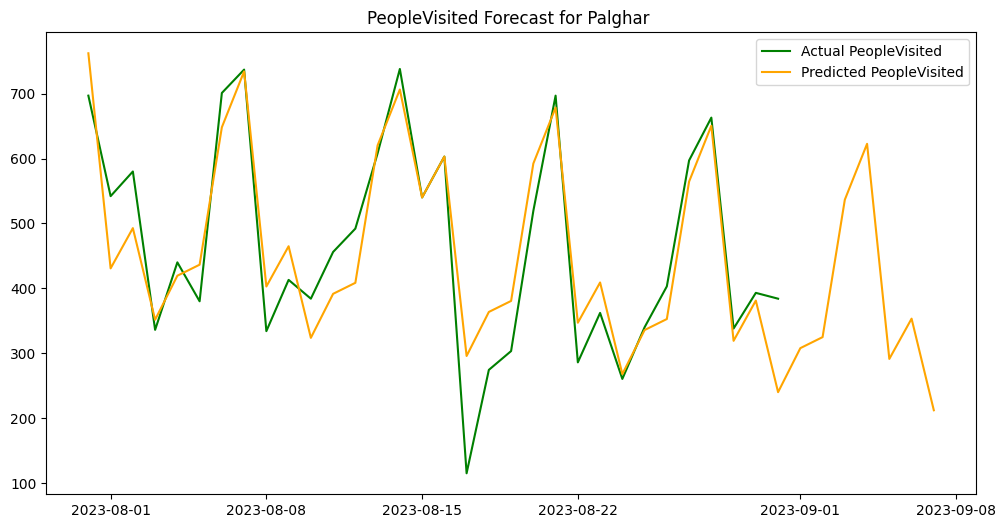

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


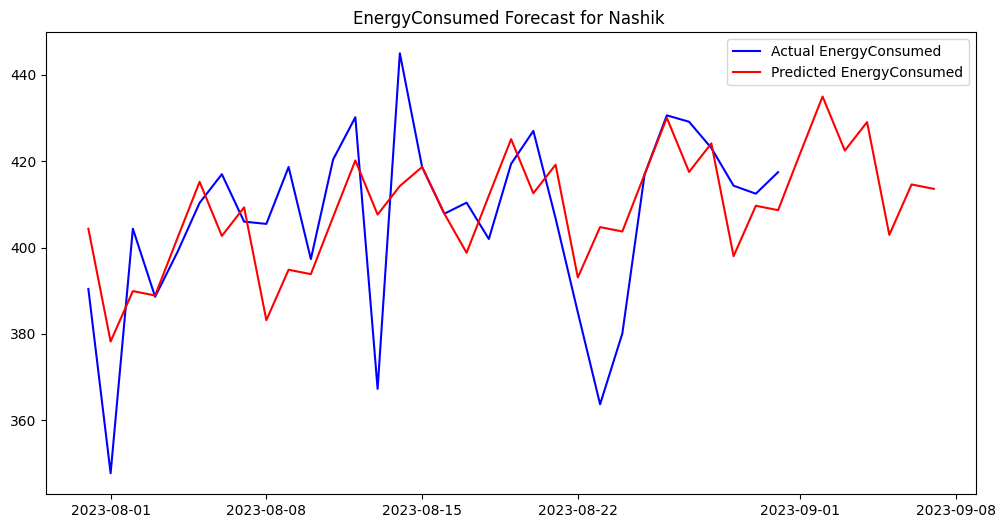

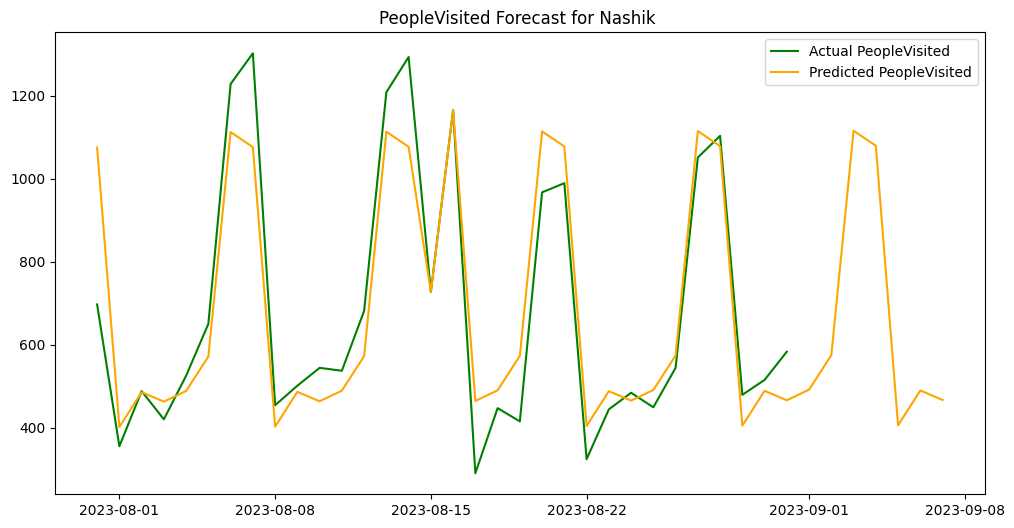

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


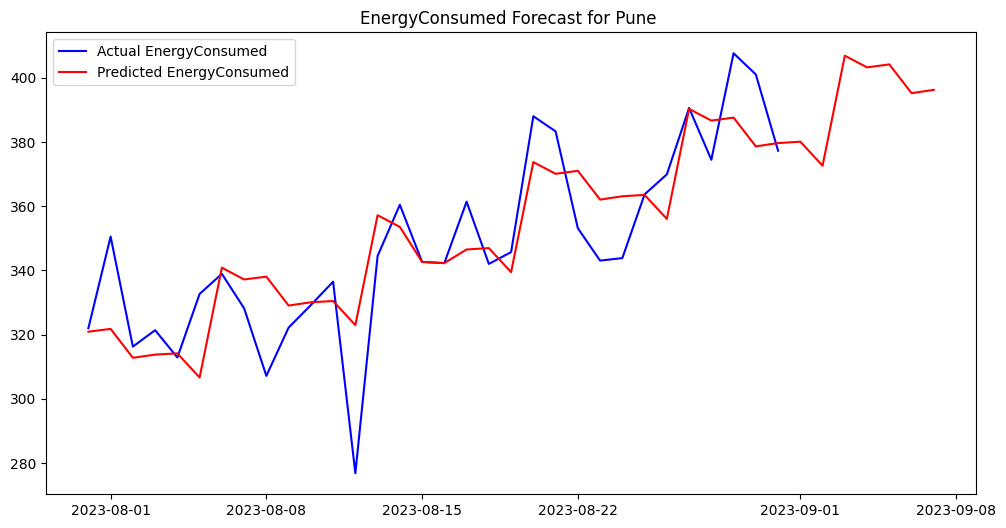

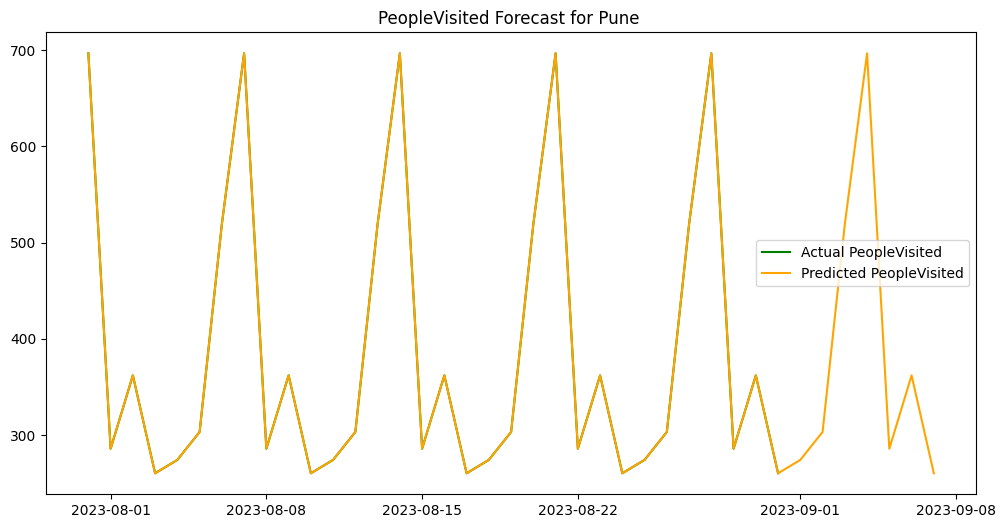

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


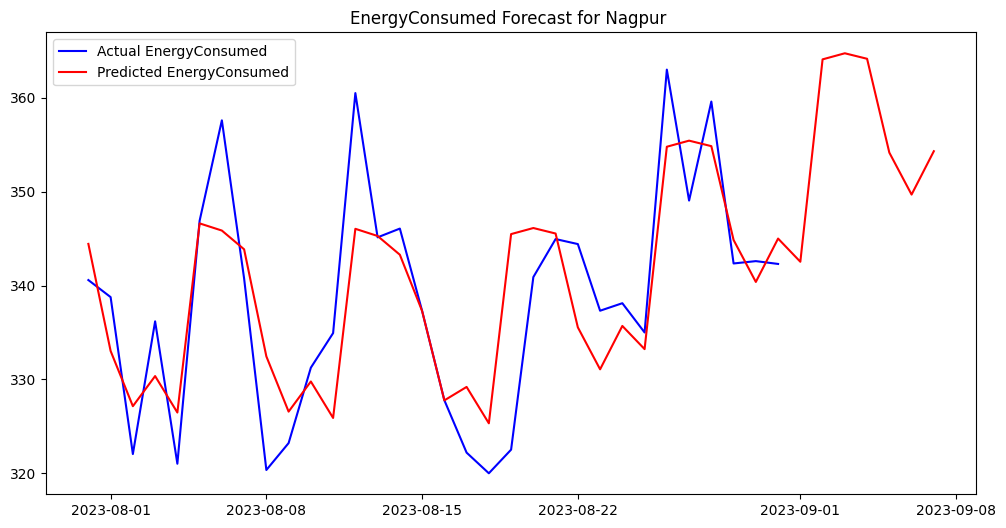

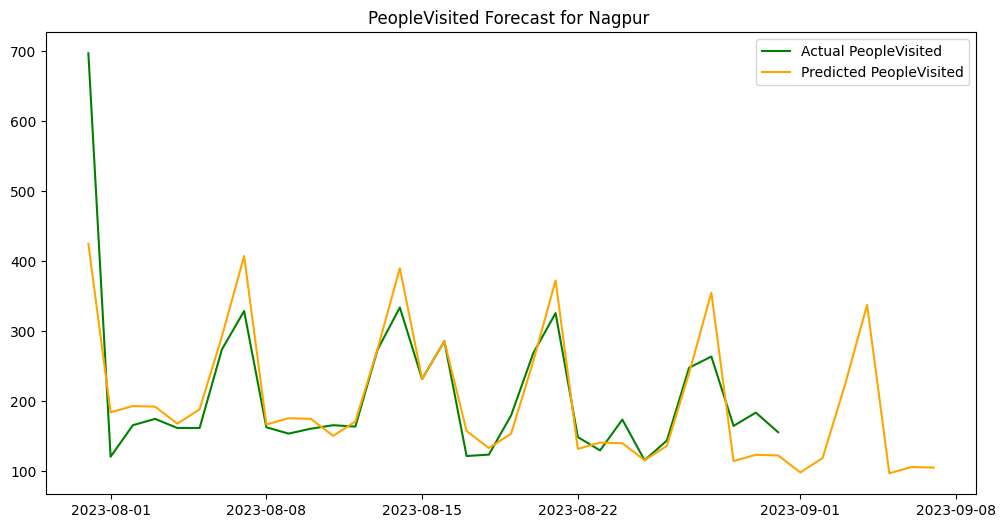

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


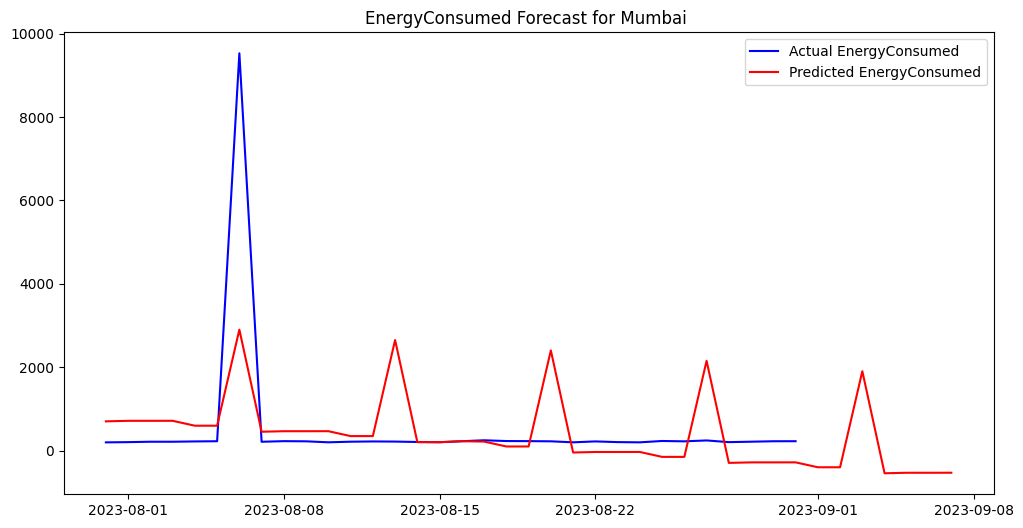

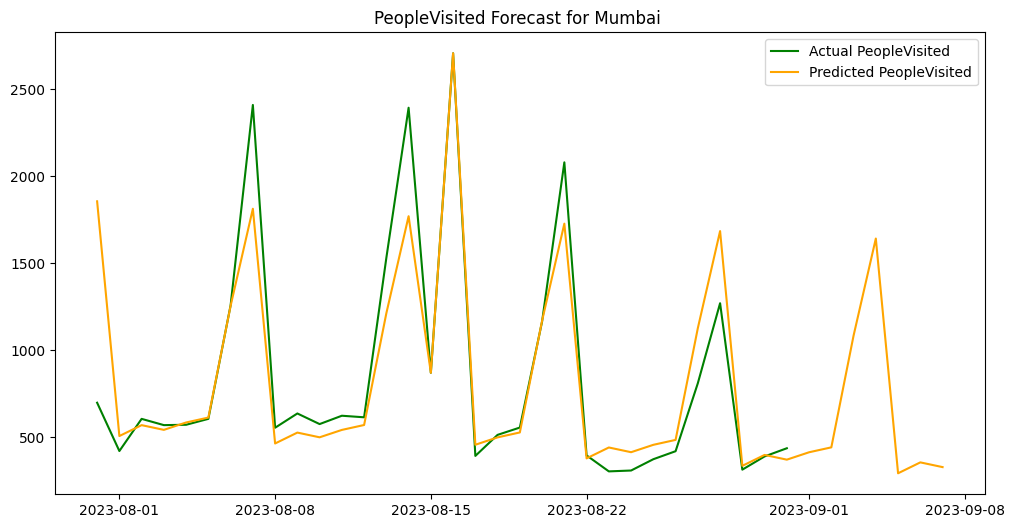

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


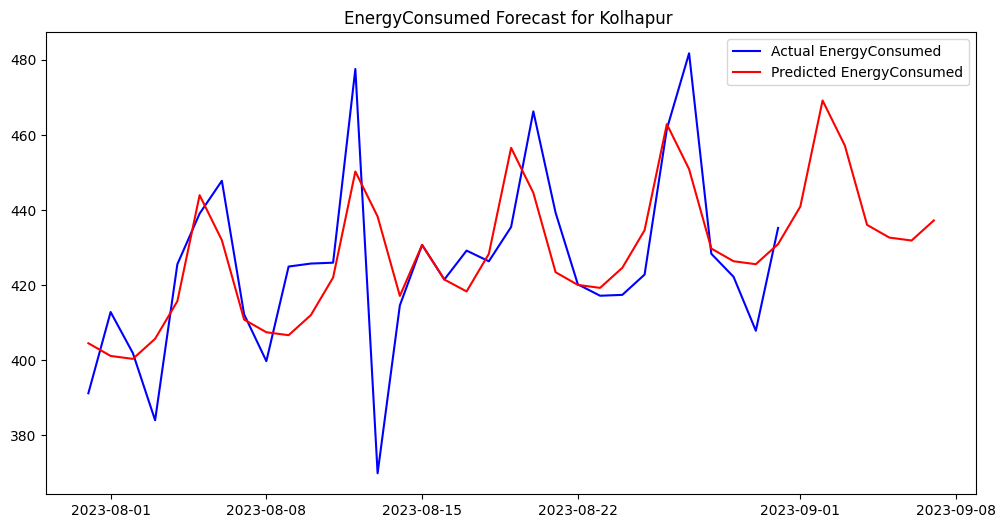

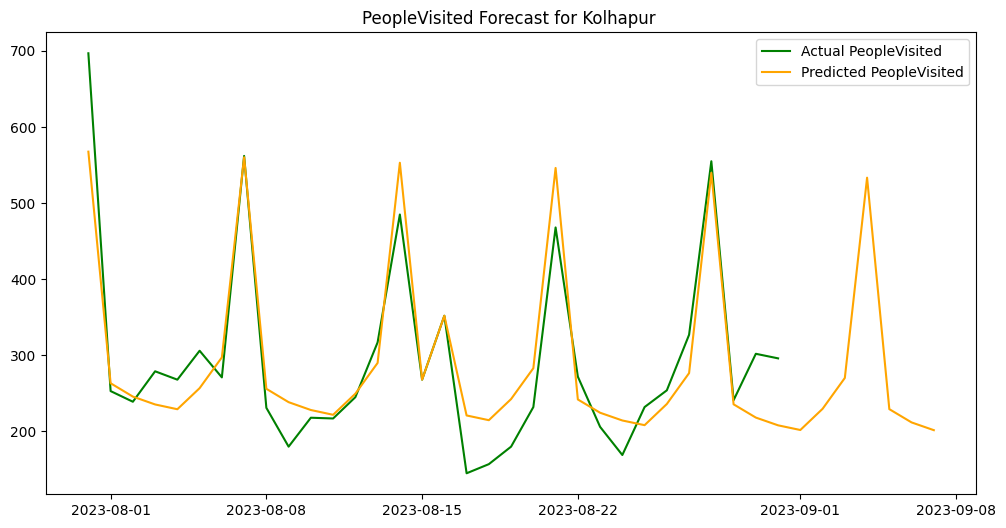

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


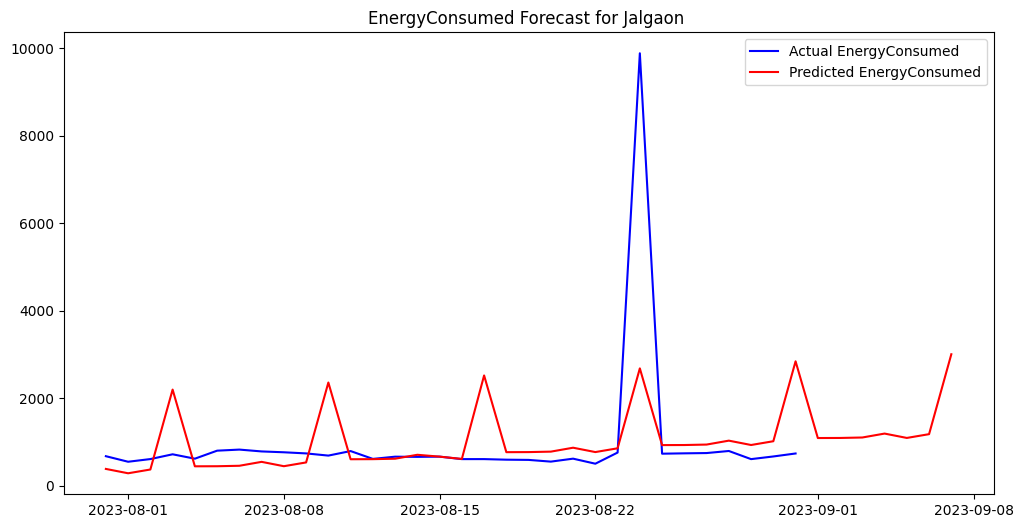

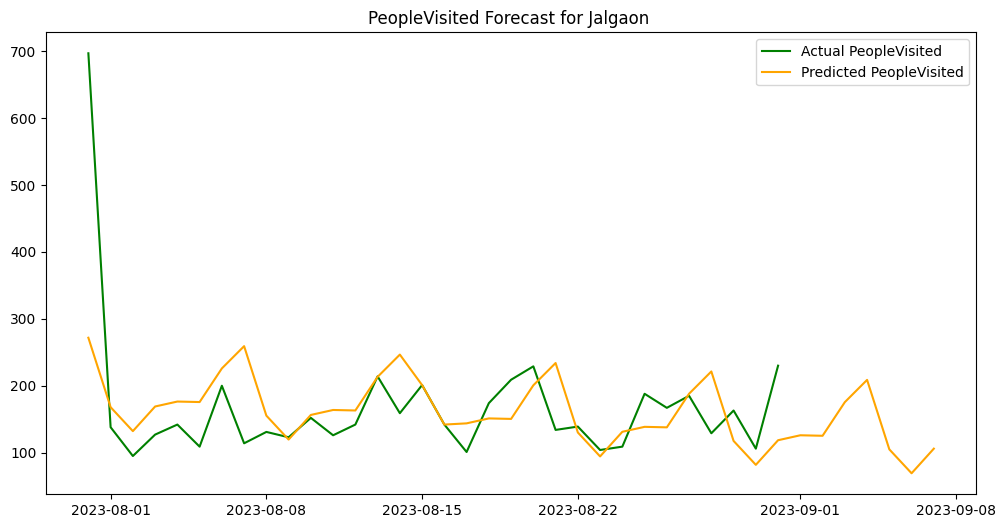

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


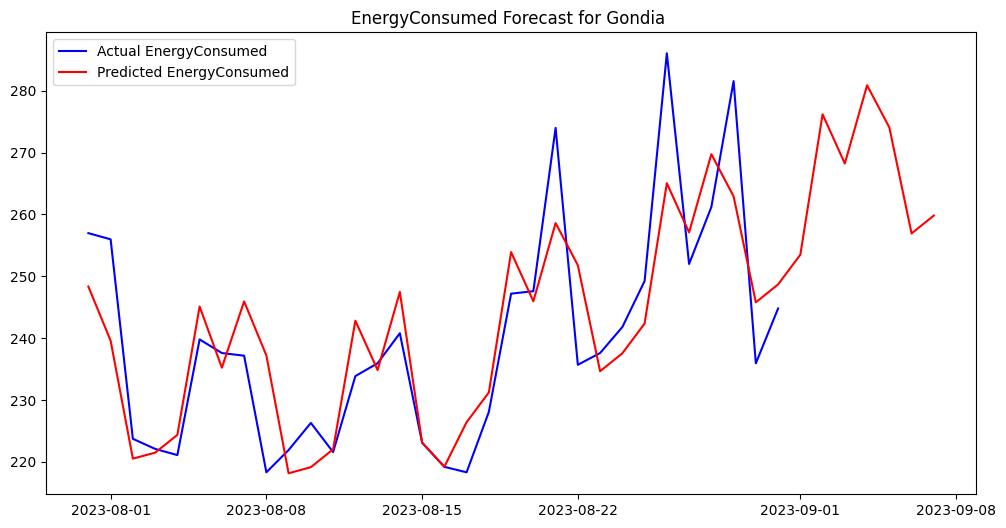

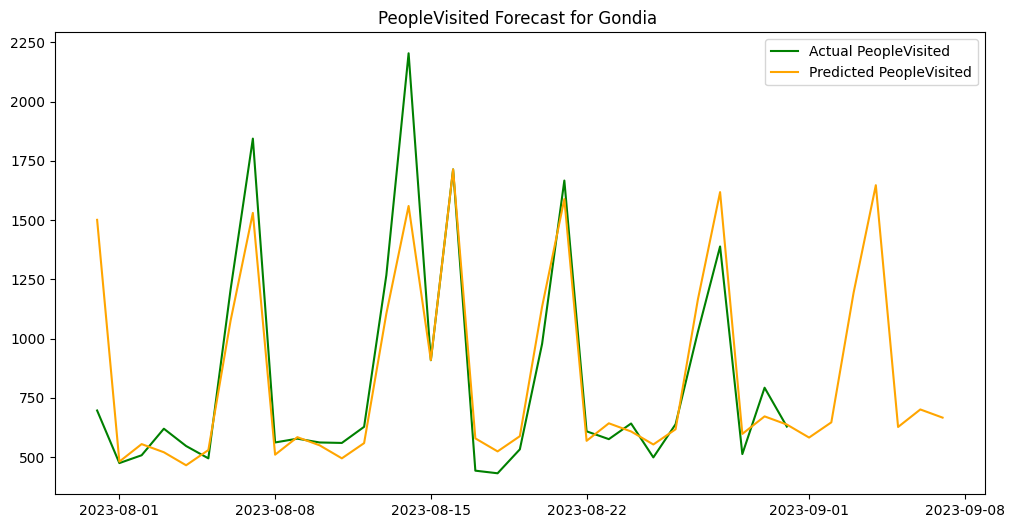

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


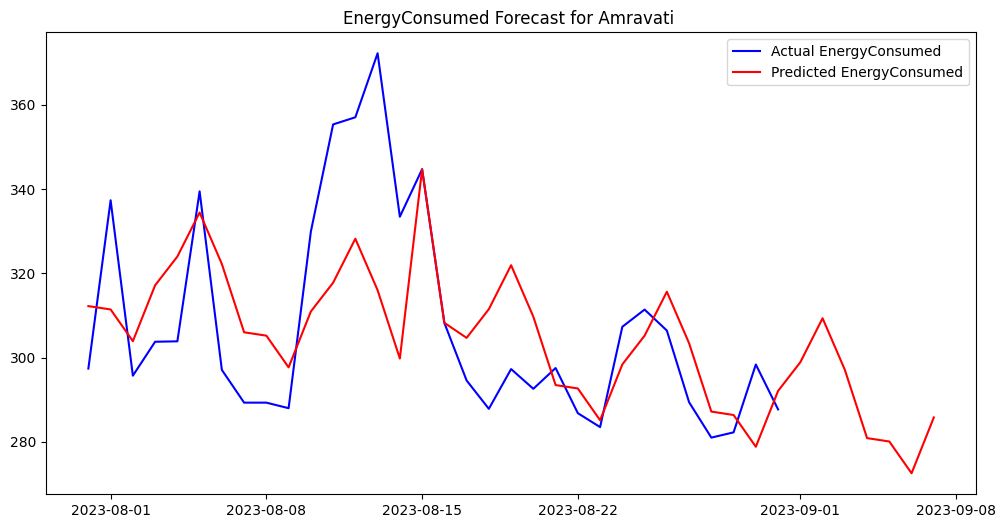

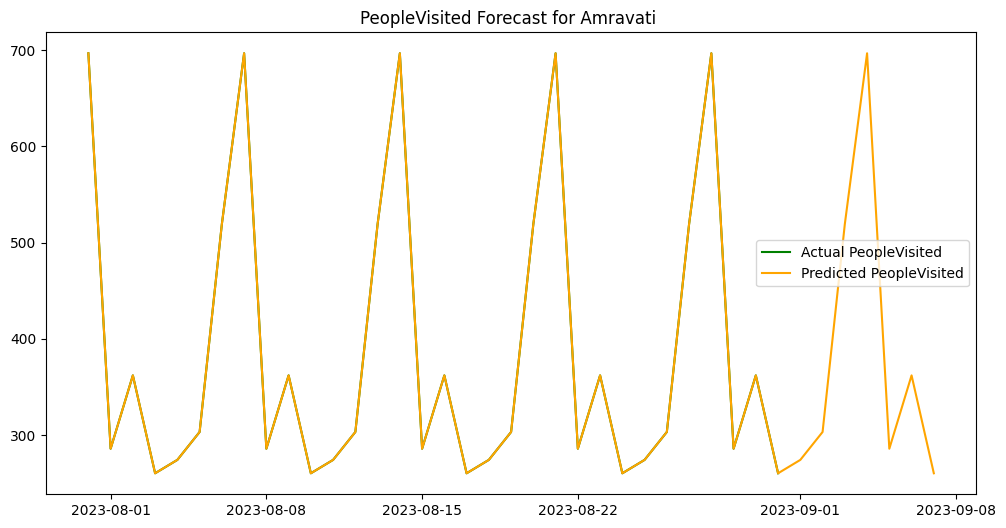

INFO:prophet:n_changepoints greater than number of observations. Using 24.


['Date', 'StoreName']


INFO:prophet:n_changepoints greater than number of observations. Using 24.


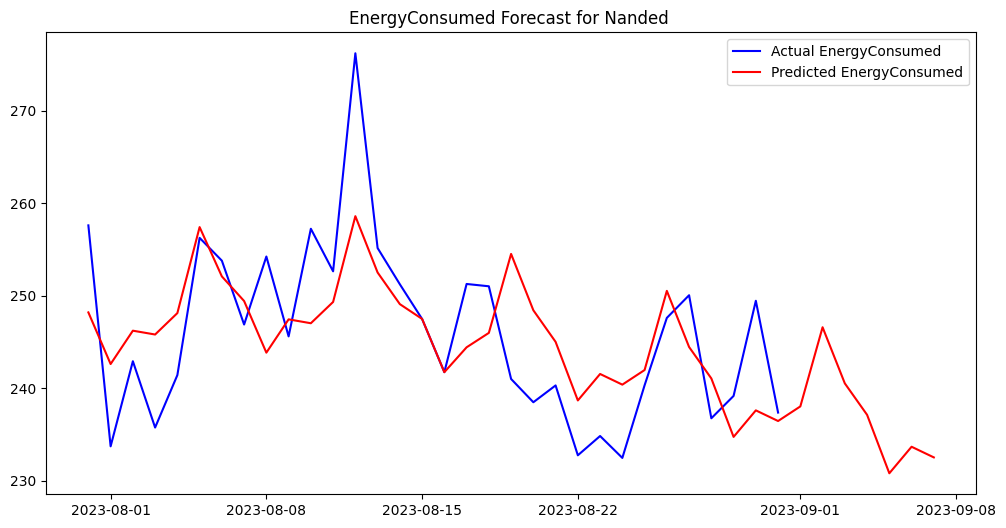

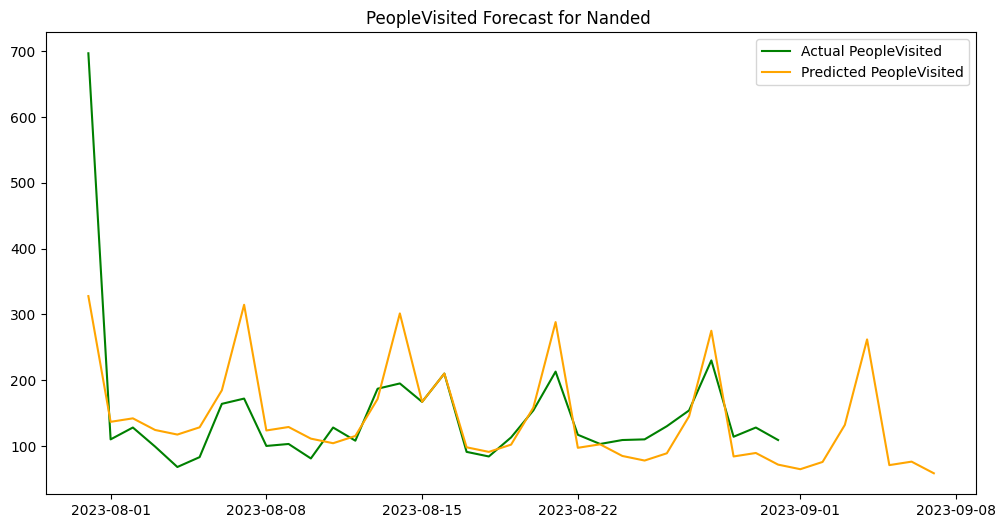

In [171]:
forecast_results = []

for store in data['StoreName'].unique():

  final_df = forecast_drill_down_store_all(data, store_name=store, forecast_period=7, holiday=holiday_df)

  forecast_results.append(final_df)

merged_forecast_df = pd.concat(forecast_results, ignore_index=True)

In [172]:
merged_forecast_df

,Date,StoreName,Forecasted EnergyConsumed,Forecasted PeopleVisited
0,2023-07-31,Akola,405,440
1,2023-08-01,Akola,405,188
2,2023-08-02,Akola,402,184
3,2023-08-03,Akola,415,192
4,2023-08-04,Akola,412,175
...,...,...,...,...
580,2023-09-03,Nanded,241,132
581,2023-09-04,Nanded,237,262
582,2023-09-05,Nanded,231,71
583,2023-09-06,Nanded,234,76


In [173]:
merged_forecast_df.to_csv('/content/EnergyForecastMathematicsClub.csv', index=False)
data.to_csv('/content/EnergyActualData.csv', index=False)

In [84]:
json_data = merged_forecast_df.to_json(orient='records', date_format='iso')
with open('/content/JSONEnergyForecastMathematicsClub.json', 'w') as json_file:
    json_file.write(json_data)
json_data

'[{"_time":"2023-07-31T00:00:00.000","panel_no":"80660005_1","Forecasted _value_kwh":37,"Forecasted _value_pcm":763},{"_time":"2023-08-01T00:00:00.000","panel_no":"80660005_1","Forecasted _value_kwh":35,"Forecasted _value_pcm":332},{"_time":"2023-08-02T00:00:00.000","panel_no":"80660005_1","Forecasted _value_kwh":31,"Forecasted _value_pcm":390},{"_time":"2023-08-03T00:00:00.000","panel_no":"80660005_1","Forecasted _value_kwh":36,"Forecasted _value_pcm":327},{"_time":"2023-08-04T00:00:00.000","panel_no":"80660005_1","Forecasted _value_kwh":36,"Forecasted _value_pcm":327},{"_time":"2023-08-05T00:00:00.000","panel_no":"80660005_1","Forecasted _value_kwh":39,"Forecasted _value_pcm":398},{"_time":"2023-08-06T00:00:00.000","panel_no":"80660005_1","Forecasted _value_kwh":37,"Forecasted _value_pcm":649},{"_time":"2023-08-07T00:00:00.000","panel_no":"80660005_1","Forecasted _value_kwh":39,"Forecasted _value_pcm":718},{"_time":"2023-08-08T00:00:00.000","panel_no":"80660005_1","Forecasted _value_